# CIFAR10 CNN

Train a simple deep CNN on the CIFAR10 small images dataset.

GPU run command with Theano backend (with TensorFlow, the GPU is automatically used):
    THEANO_FLAGS=mode=FAST_RUN,device=gpu,floatx=float32 python cifar10_cnn.py

It gets down to 0.65 test logloss in 25 epochs, and down to 0.55 after 50 epochs.
(it's still underfitting at that point, though).

In [54]:
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator

In [55]:
import os
import pickle
import numpy as np

In [56]:
batch_size = 32
num_classes = 10
epochs = 200
data_augmentation = True
num_predictions = 20
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'keras_cifar10_trained_model.h5'

In [57]:
# The data, shuffled and split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [58]:
import PIL

In [59]:
x_train[1:].shape

(49999, 32, 32, 3)

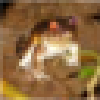

In [61]:
image = PIL.Image.fromarray(x_train[0]).resize((100,100))
image

In [63]:
image.size

(100, 100)

In [17]:
from conx import *

net = Network("CIRAR10")
net.add(Layer("input", (32, 32, 3))) # depends on K.image_data_format(), right?
net.add(Conv2DLayer("conv1", 32, (3, 3), padding='same', activation='relu'))
net.add(Conv2DLayer("conv2", 32, (3, 3), activation='relu'))
net.add(MaxPool2DLayer("pool1", pool_size=(2, 2), dropout=0.25))
net.add(Conv2DLayer("conv3", 64, (3, 3), padding='same', activation='relu'))
net.add(Conv2DLayer("conv4", 64, (3, 3), activation='relu'))
net.add(MaxPool2DLayer("pool2", pool_size=(2, 2), dropout=0.25))
net.add(FlattenLayer("flatten"))
net.add(Layer("hidden1", 512, activation='relu', vshape=(16, 32), dropout=0.5))
net.add(Layer("output", num_classes, activation='softmax'))
net.connect()

# initiate RMSprop optimizer
opt = RMSprop(lr=0.0001, decay=1e-6)

net.compile(loss='categorical_crossentropy',
            optimizer=opt)

# Let's train the model using RMSprop
net.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
model = net.model

In [18]:
net.dashboard()

<IPython.core.display.Javascript object>

In [19]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [20]:
net.propagate(x_train[0])

[0.1005762,
 0.094180107,
 0.10122274,
 0.10924178,
 0.097026072,
 0.10193674,
 0.097991653,
 0.09543433,
 0.1021902,
 0.10020017]

In [21]:
net.set_dataset_direct(x_train, y_train)

Input Summary:
   length  : 50000
   training: 50000
   testing : 0
   shape  : (32, 32, 3)
   range  : (0.0, 1.0)
Target Summary:
   length  : 50000
   training: 50000
   testing : 0
   shape  : (10,)
   range  : (0.0, 1.0)


**TESTING**

In [25]:
import keras.backend as K

In [23]:
weights = net.model.layers[1].get_weights()

In [24]:
[x.shape for x in weights]

[(3, 3, 3, 32), (32,)]

In [26]:
K.image_data_format()

'channels_last'

* Convolution filter is (3,3)
* Image is (32, 32, 3) (because of K.image_data_format())

In [40]:
weights[0][0,0].shape # image

(3, 32)

In [50]:
weights[0][:,:,0,0].shape # just the first two dimensions, the filter

(3, 3)

In [51]:
weights[0][:,:,0,0]

array([[ 0.01075616,  0.01086534, -0.0041749 ],
       [-0.10892708, -0.10641845, -0.04017058],
       [-0.11515775,  0.01121084, -0.09700422]], dtype=float32)

In [27]:
3 * 3 * 3 * 32 + 32

896

In [29]:
net.model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 32, 32, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 32, 32, 32)        896       
_________________________________________________________________
conv2 (Conv2D)               (None, 30, 30, 32)        9248      
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv3 (Conv2D)               (None, 15, 15, 64)        18496     
_________________________________________________________________
conv4 (Conv2D)               (None, 13, 13, 64)        36928     
__________

**END TESTING**

In [13]:
net.propagate(x_test[0])

[0.10593142,
 0.090718798,
 0.11996857,
 0.093882129,
 0.091921531,
 0.099259503,
 0.10394023,
 0.093262888,
 0.10208549,
 0.099029452]

In [52]:
if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    model.fit_generator(datagen.flow(x_train, y_train,
                                     batch_size=batch_size),
                        steps_per_epoch=x_train.shape[0] // batch_size,
                        epochs=epochs,
                        validation_data=(x_test, y_test))

Using real-time data augmentation.
Epoch 1/200
1562/1562 [==============================] - 455s - loss: 1.8629 - acc: 0.3134 - val_loss: 1.5768 - val_acc: 0.4368
Epoch 2/200
1562/1562 [==============================] - 471s - loss: 1.5649 - acc: 0.4293 - val_loss: 1.3569 - val_acc: 0.5179
Epoch 3/200
1562/1562 [==============================] - 470s - loss: 1.4413 - acc: 0.4797 - val_loss: 1.3091 - val_acc: 0.5330
Epoch 4/200
1562/1562 [==============================] - 468s - loss: 1.3592 - acc: 0.5117 - val_loss: 1.1923 - val_acc: 0.5762
Epoch 5/200
1562/1562 [==============================] - 446s - loss: 1.2914 - acc: 0.5387 - val_loss: 1.1345 - val_acc: 0.6012
Epoch 6/200
1562/1562 [==============================] - 432s - loss: 1.2267 - acc: 0.5622 - val_loss: 1.0649 - val_acc: 0.6279
Epoch 7/200
1562/1562 [==============================] - 435s - loss: 1.1752 - acc: 0.5843 - val_loss: 1.0042 - val_acc: 0.6471
Epoch 8/200
1562/1562 [==============================] - 445s - loss:

KeyboardInterrupt: 

In [ ]:
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

# Load label names to use in prediction results
label_list_path = 'datasets/cifar-10-batches-py/batches.meta'


keras_dir = os.path.expanduser(os.path.join('~', '.keras'))
datadir_base = os.path.expanduser(keras_dir)
if not os.access(datadir_base, os.W_OK):
    datadir_base = os.path.join('/tmp', '.keras')
label_list_path = os.path.join(datadir_base, label_list_path)

with open(label_list_path, mode='rb') as f:
    labels = pickle.load(f)

# Evaluate model with test data set and share sample prediction results
evaluation = model.evaluate_generator(datagen.flow(x_test, y_test,
                                      batch_size=batch_size),
                                      steps=x_test.shape[0] // batch_size)

print('Model Accuracy = %.2f' % (evaluation[1]))

predict_gen = model.predict_generator(datagen.flow(x_test, y_test,
                                      batch_size=batch_size),
                                      steps=x_test.shape[0] // batch_size)

for predict_index, predicted_y in enumerate(predict_gen):
    actual_label = labels['label_names'][np.argmax(y_test[predict_index])]
    predicted_label = labels['label_names'][np.argmax(predicted_y)]
    print('Actual Label = %s vs. Predicted Label = %s' % (actual_label,
                                                          predicted_label))
    if predict_index == num_predictions:
        break